<H1>RNG</H1> 
Use a single qubit (or multiples) to create a series of random numbers. Going to try out a number of ideas. <br> 
<ol>
    <li> just sample a series of qubits without initialization</li>
    <li> initalize to ground state and allow $T_2$ (shorter than $T_1$) to evolve, ie do a Hadamard then a X or Y rotation</li>
</ol>
<hr>
<H2>Modification history </H2><br> 
<table>
    <tr>
        <th> Modified </th>
        <th> By </th>
        <th> Reason </th>
    </tr>
    <tr> 
        <td> 20-Aug-25 </td>
        <td> CBL </td> 
        <td> Original </td>
    </tr>
</table>
<hr> 
<H2> References </H2> 
<a href="https://docs.quantum.ibm.com/guides/install-qiskit"> Install Qikit </a> <br> 
<a href="https://docs.quantum.ibm.com/guides/hello-world"> qiskit hello world </a> <br> 
<a href="https://qiskit-community.github.io/qiskit-dynamics/"> Qiskit dynamics</a> <br> 
<a href="https://pypi.org/project/qiskit/"> Pypi qiskit page</a> <br> 
<a href="https://docs.quantum.ibm.com/api/qiskit/visualization"> Visualization</a> <br> 
<hr>
<H2> Notes </H2>
Hit every cell in order to get this to work. I may be overloaded on imports. This was a first pass. <br> 
If you want to run this on a real processor, you need to apply for an account and get a token. <br> 
This example uses the AER simulator package. <br> 
I am using the sampler rather than the estimator in this case. The estimator returns individual expection values. The sampler will return the value of each shot. 

<br> 

In [1]:
# my standard includes
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as const
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli
from scipy.spatial.transform import Rotation as R

import struct

<H1> Basic Concepts </H1>
Placing a qubit into a superposition state and then measuring it, should be a real random distribution 50% distribition of 1 and 0. We can either
make a number of measurements on a single qubit and then make a binary string of arbitrary length OR select a number of qubits that are independent
and do the same operation on all of them to make a string. The length of the single string or width of the circuit will determine the integer number size. If
we call L the string length then the number sequence will be {0:$2^L$}. <br> 
Code description: 
<ul>
    <li> nqbit - number of qubits needed to run the experiment. </li>
    <li> ncbit - number of classical bits needed - this is a register to put the results in. </li>
    <li> creg - a classical register to collect the results. </li>
    <li> qreg - the register of quantum bits that will be run on a simulator or back end. </li>
    <li> nshots - number of measurements to be made per point or number of times to perform the experiment. </li>
    <li> qc - The quantum circuit. </li>
    <li> sampler - permits the system to know that we want to run this circiut multiple times and collect the results. (gives a lot of information to runtime.)</li>
</ul>

<H1> Setup </H1>
The code below sets up the overall system to run. It should be pretty well inline documented below. 

In [2]:
# instantiate the AER simulator
# with an account, you can specify a backend error model based off of one of the IBM systems if desired.
# 
sim = AerSimulator()
# Define the number of quantum bits. For this problem (double slit) we can use a single qubit and use
# the superposition to calculate the phase of the complete system. 
nqbit     = 1
# for using the sampler, we need some clasical bits to store the output data
ncbit     = 1
# Create the actual registers. 
creg = ClassicalRegister(ncbit, 'cbit')
qreg = QuantumRegister(nqbit)
# Create a very simple quantum circuit.
# https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit
# Here we tell the circuit that we want to use the quantum and classical registers we created above. 
qc   = QuantumCircuit(qreg, creg)
# Create an estimator - this gives the expectation value of each system. 
# the number of shots is the number of times that the experiment is replicated to produce statistics. 
# In the estimator, you specify the precision instead, this is the default and can be overriden in 
# the estimator run command. Default precision is 0
#
# reference: https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/sampler-v2
#
sampler = SamplerV2()

<H2> Create the quantum circuit </H2>
This assumes that the resources have been previously allocated. <br> 
The Hadamard gate puts the qubit into the state ${1\over {\sqrt{2}}}(\ket{0} + \ket{1})$

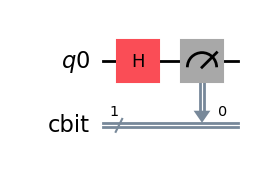

In [3]:
# Apply a hadamard on qubit 0 - this creates equal path case, superposition
# The Hadamard gate can also be expressed as a 90º rotation around the Y-axis, followed by a 180º around the X-axis. 
#
qc.h(0)
# finally perform a measurement
# qubit 0 results stored in classical register 0
qc_measured = qc.measure(0, 0)
# And make a pretty picture of the circuit.
qc.draw(output='mpl')

In [4]:
# Tell the sampler how you want to do the program. 
# qc is the quantum circuit
# The following reference has a very good example on how to use this. 
# https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.primitives.StatevectorSampler
# scroll down to the example where the 'pub' is created. 
#
# pub stands for Primitive unified bloc
# multiple pubs may be submitted. 
# details on pubs - https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output
#
# details on options - https://quantum.cloud.ibm.com/docs/en/guides/specify-runtime-options
#
# estimator pubs
# quantum circuit
# A list of one or more observables: [ObservableArrayLike, Pauli, SparsePauliOp, PauliList, str]
# Collection of parameter objects, in this case theta
# 
# Need to introduce the number of shots in this system. 
#
# lets say I want to use this single qubit to generate a series of 16 bit numbers. Then I want the number of shots to 
# be evenly divisable by 16
BitLength = 16
DesiredNumbers = 100
NShots = DesiredNumbers * BitLength
# Run the job
job = sampler.run([qc],shots=NShots)
# get the results
result = job.result()[0] # only 1 qubit

In [5]:
# show the count distribution
result.data['cbit'].get_counts()
#counts = result.data.get_counts() 

{'0': 854, '1': 746}

In [6]:
def bit2N(s):
    """
    helper function, create a number of arbitrary length depending on input list. 
    @param s - input string, need 8 input bits to produce one byte
    """
    rv = 0
    for i in range(len(s)):
        rv = rv + s[i] * np.power(2,i)
    return rv

In [7]:
# get the individual shot data
shot_data = result.data['cbit'].array

In [8]:
div = np.split(shot_data, DesiredNumbers)

In [10]:
x = div[1]
print(bit2N(x))

[26174]


/var/folders/14/9z9f9pnd13v8hyxk9rn_htc40000gn/T/ipykernel_92405/32935730.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xy[i] = bit2N(div[i])


(array([ 9., 10., 12.,  6.,  6.,  9., 13.,  7., 16., 12.]),
 array([  209. ,  6727.3, 13245.6, 19763.9, 26282.2, 32800.5, 39318.8,
        45837.1, 52355.4, 58873.7, 65392. ]),
 <BarContainer object of 10 artists>)

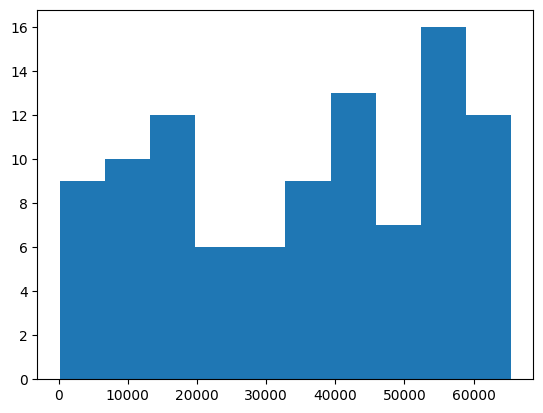

In [12]:
L = len(div)
xy = np.zeros(L)
for i in range(L):
    xy[i] = bit2N(div[i])
plt.hist(xy)

In [17]:
def SaveNumbers(x):
    fd = open('numbers.txt','w')
    for n in x:
        fd.write(str(n))
    fd.close()

In [18]:
SaveNumbers(xy)